## Import libraries

In [1]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from mtcnn.mtcnn import MTCNN
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import json
import time

## Face detection (MTCNN)

In [ ]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

####### Change as per your paths
dataset_path = 'dataset'
model_path = 'Facenet/facenet_keras_2024.h5'
output_model_path = 'Finetuned_FaceNet/finetuned_facenet_mtcnn.keras' 

# Parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 20

# Initialize MTCNN detector
detector = MTCNN()

# Load the pre-trained FaceNet model
base_model = load_model(model_path)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Get number of classes
class_names = sorted(os.listdir(dataset_path))
print(f"Classes found: {class_names}")
num_classes = len(class_names)

# Helper function to extract face from bounding box
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # Ensure coordinates are within image bounds
    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(x2, w), min(y2, h)
    if x2 <= x1 or y2 <= y1:  # Invalid box
        return None
    face = img[y1:y2, x1:x2]
    return face

# Load and preprocess data with MTCNN face detection
def load_data():
    X, y = [], []
    skipped_images = 0
    for idx, person in enumerate(class_names):
        person_path = os.path.join(dataset_path, person)
        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            # Load image with OpenCV
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load {img_path}, skipping.")
                skipped_images += 1
                continue
            
            # Convert to RGB for MTCNN
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Detect faces
            faces = detector.detect_faces(rgb_img)

            if len(faces) > 0:
                # Use the largest face (by area)
                main_face = max(faces, key=lambda x: x['box'][2] * x['box'][3])
                face_img = get_face(img, main_face['box'])
                
                if face_img is None:
                    print(f"Invalid face box in {img_path}, skipping.")
                    skipped_images += 1
                    continue
                
                # Resize and preprocess
                face_img = cv2.resize(face_img, IMG_SIZE)
                face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                face_array = face_img.astype('float32') / 255.0  # Normalize to [0,1]
                
                # Debug: Confirm detection
                print(f"Detected face in {img_path}: box={main_face['box']}")
                
                X.append(face_array)
                y.append(idx)
            else:
                print(f"No face detected in {img_path}")
                skipped_images += 1
    print(f"Total images skipped: {skipped_images}")
    return np.array(X), np.array(y)

Classes found: ['aaryan', 'ethan', 'eunice', 'jinwei', 'jonathan', 'junyong']


In [3]:
# inspect the custom lambda layers loaded from the pretrained weight
lambda_layer = [layer for layer in base_model.layers if isinstance(layer, layers.Lambda)]
for layer in lambda_layer:
    print(layer.get_config())

{'name': 'lambda', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'scaling', 'registered_name': 'function'}, 'output_shape': (17, 17, 256), 'arguments': {'scale': 0.17}}
{'name': 'lambda_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'scaling', 'registered_name': 'function'}, 'output_shape': (17, 17, 256), 'arguments': {'scale': 0.17}}
{'name': 'lambda_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'scaling', 'registered_name': 'function'}, 'output_shape': (17, 17, 256), 'arguments': {'scale': 0.17}}
{'name': 'la

In [3]:
# Load dataset
X, y = load_data()

# Check if data is loaded successfully
if len(X) == 0:
    raise ValueError("No valid face data loaded. Check dataset or MTCNN detection.")

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Detected face in dataset\aaryan\aaryan_01.jpg: box=[200, 169, 202, 264]
Detected face in dataset\aaryan\aaryan_02.jpg: box=[75, 62, 60, 77]
Detected face in dataset\aaryan\aaryan_03.jpg: box=[562, 615, 437, 573]
Detected face in dataset\aaryan\aaryan_04.jpg: box=[1177, 1402, 817, 1055]
Detected face in dataset\aaryan\aaryan_05.jpg: box=[975, 1537, 919, 1214]
Detected face in dataset\aaryan\aaryan_06.jpg: box=[573, 805, 1199, 1625]
Detected face in dataset\aaryan\aaryan_07.jpg: box=[1043, 1685, 951, 1334]
Detected face in dataset\aaryan\aaryan_08.jpg: box=[1110, 1506, 897, 1175]
Detected face in dataset\aaryan\aaryan_09.jpg: box=[1115, 1486, 832, 1143]
Detected face in dataset\aaryan\aaryan_10.jpg: box=[1236, 1485, 925, 1229]
Detected face in dataset\aaryan\aaryan_11.jpg: box=[1375, 1446, 684, 1008]
Detected face in dataset\aaryan\aaryan_12.jpg: box=[628, 1186, 1045, 1357]
Detected face in dataset\aaryan\aaryan_13.jpg: box=[642, 1150, 1055, 1371]
Detected face in dataset\aaryan\aaryan_1

In [5]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(72, 160, 160, 3) (72,)
(18, 160, 160, 3) (18,)


## Face recognition (Inception Resnet V1)

In [7]:
# Add classification head
x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create a callback that saves the model's weights during training
class SaveBaseModelCallback(Callback):
    def __init__(self, base_model, filepath, monitor='val_loss', mode='min'):
        super().__init__()
        self.base_model = base_model
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = np.inf if mode == 'min' else -np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        if ((self.mode == 'min' and current < self.best) or
            (self.mode == 'max' and current > self.best)):
            print(f"\nSaving improved base model at epoch {epoch+1}")
            self.best = current
            self.base_model.save(self.filepath)

# Custom callback to compute precision, recall, and F1-score after each epoch
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(X_val), axis=1)  # Get predicted class labels
        y_true = y_val

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        accuracy = accuracy_score(y_true, y_pred)

        print(f"\nEpoch {epoch+1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Create a checkpoint callback to save the model
base_model_saver = SaveBaseModelCallback(base_model, output_model_path)

# Create new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy')

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val), 
                    callbacks=[base_model_saver, MetricsCallback()])

# print(f"Model fine-tuned and saved as {output_model_path}")
# print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
# print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Predict on validation set
y_pred_finetune = np.argmax(model.predict(X_val), axis=1)
y_true = y_val

# Calculate metrics for the pretrained model
precision_finetune = precision_score(y_true, y_pred_finetune, average='macro')
recall_finetune = recall_score(y_true, y_pred_finetune, average='macro')
f1_finetune = f1_score(y_true, y_pred_finetune, average='macro')
accuracy_finetune = accuracy_score(y_true, y_pred_finetune)

print(f"Finetuned Model - Precision: {precision_finetune:.4f}, Recall: {recall_finetune:.4f}, F1-score: {f1_finetune:.4f}, Accuracy: {accuracy_finetune:.4f}")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 2.2461
Saving improved base model at epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Epoch 1 - Precision: 0.1875, Recall: 0.3333, F1-score: 0.2338, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 2.2260 - val_loss: 1.4214
Epoch 2/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - loss: 1.3221
Saving improved base model at epoch 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

Epoch 2 - Precision: 0.6944, Recall: 0.6667, F1-score: 0.6468, Accuracy: 0.6667
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 1.3233 - val_loss: 1.0585
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - loss: 0.7752
Saving improved base model at epoch 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step

Epoch 3 - Precision: 0.8194, Recall: 0.7778, F1-score: 0.7563, Accuracy: 0.7778
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.7768 - val_loss: 0.8226
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.4597
Saving improved base model at epoch 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

Epoch 4 - Precision: 0.9167, Recall: 0.8889, F1-score: 0.8690, Accuracy: 0.8889
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.4612 - val_loss: 0.6579
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.4501
Saving improved base model at epoch 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [6]:
# Save the metrics to a JSON file

metrics = {
    "Precision": precision_finetune,
    "Recall": recall_finetune,
    "F1-score": f1_finetune,
    "Accuracy": accuracy_finetune
}

# Define the file path for saving the metrics
file_path = 'facenet_finetune_results.json'

# Save the metrics to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

print(f"Metrics saved to {file_path}")


Metrics saved to facenet_finetune_results.json


### Evaluate on pretrained model

In [10]:
# Load the pre-trained FaceNet model
base_model = load_model(model_path)

# freeze all layers to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create new model
model_pretrained = Model(inputs=base_model.input, outputs=predictions)

# Compile with a lower learning rate
model_pretrained.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy')

# Train the model
history = model_pretrained.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val), 
                    callbacks=[MetricsCallback()])

# Predict on validation set
y_pred_pretrained = np.argmax(model_pretrained.predict(X_val), axis=1)
y_true = y_val

# Calculate metrics for the pretrained model
precision_pretrained = precision_score(y_true, y_pred_pretrained, average='macro')
recall_pretrained = recall_score(y_true, y_pred_pretrained, average='macro')
f1_pretrained = f1_score(y_true, y_pred_pretrained, average='macro')
accuracy_pretrained = accuracy_score(y_true, y_pred_pretrained)

print(f"Pretrained Model - Precision: {precision_pretrained:.4f}, Recall: {recall_pretrained:.4f}, F1-score: {f1_pretrained:.4f}, Accuracy: {accuracy_pretrained:.4f}")

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steptep - loss: 1.988

Epoch 1 - Precision: 0.1865, Recall: 0.2778, F1-score: 0.2148, Accuracy: 0.2778
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 1.9879 - val_loss: 1.6926
Epoch 2/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.81

Epoch 2 - Precision: 0.1865, Recall: 0.2778, F1-score: 0.2148, Accuracy: 0.2778
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - loss: 1.8069 - val_loss: 1.6450
Epoch 3/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1.79

Epoch 3 - Precision: 0.2619, Recall: 0.3333, F1-score: 0.2667, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - loss: 1.8007 - val_loss: 1.5991
Epoch 4/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 1.81

Epoch 4 - Precision: 0.3532, Recall: 0.3889, F1-score: 0.3407, Accuracy: 0.3889
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - loss: 1.8492 - val_loss: 1.5541
Epoch 5/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 1.70

Epoch 5 - Precision: 0.3889, Recall: 0.4444, F1-score: 0.3926, Accuracy: 0.4444
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - loss: 1.7067 - val_loss: 1.5107
Epoch 6/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.63

Epoch 6 - Precision: 0.5667, Recall: 0.5000, F1-score: 0.4852, Accuracy: 0.5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 1.6274 - val_loss: 1.4697
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.62

Epoch 7 - Precision: 0.5667, Recall: 0.5000, F1-score: 0.4852, Accuracy: 0.5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - loss: 1.6327 - val_loss: 1.4300
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 1.74

Epoch 8 - Precision: 0.5667, Recall: 0.5000, F1-score: 0.4852, Accuracy: 0.5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - loss: 1.7486 - val_loss: 1.3909
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.74

Epoch 9 - Precision: 0.6714, Recall: 0.6667, F1-score: 0.6083, Accuracy: 0.6667
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - loss: 1.7579 - val_loss: 1.3526
Epoch 10/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 1.57

Epoch 10 - Precision: 0.6714, Recall: 0.6667, F1-score: 0.6083, Accuracy: 0.6667
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - loss: 1.5818 - val_loss: 1.3151
Epoch 11/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.71

Epoch 11 - Precision: 0.7000, Recall: 0.7778, F1-score: 0.7167, Accuracy: 0.7778
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - loss: 1.6920 - val_loss: 1.2783
Epoch 12/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1.63

Epoch 12 - Precision: 0.7000, Recall: 0.7778, F1-score: 0.7167, Accuracy: 0.7778
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - loss: 1.6274 - val_loss: 1.2431
Epoch 13/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.31

Epoch 13 - Precision: 0.7000, Recall: 0.7778, F1-score: 0.7167, Accuracy: 0.7778
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - loss: 1.3336 - val_loss: 1.2096
Epoch 14/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 1.33

Epoch 14 - Precision: 0.7000, Recall: 0.7778, F1-score: 0.7167, Accuracy: 0.7778
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 1.3464 - val_loss: 1.1777
Epoch 15/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.64

Epoch 15 - Precision: 0.7000, Recall: 0.7778, F1-score: 0.7167, Accuracy: 0.7778
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - loss: 1.6282 - val_loss: 1.1461
Epoch 16/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.38

Epoch 16 - Precision: 0.7250, Recall: 0.8333, F1-score: 0.7679, Accuracy: 0.8333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - loss: 1.3805 - val_loss: 1.1157
Epoch 17/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1.24

Epoch 17 - Precision: 0.7250, Recall: 0.8333, F1-score: 0.7679, Accuracy: 0.8333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - loss: 1.2541 - val_loss: 1.0861
Epoch 18/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1.43

Epoch 18 - Precision: 0.7250, Recall: 0.8333, F1-score: 0.7679, Accuracy: 0.8333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - loss: 1.4333 - val_loss: 1.0573
Epoch 19/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.51

Epoch 19 - Precision: 0.7250, Recall: 0.8333, F1-score: 0.7679, Accuracy: 0.8333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - loss: 1.5051 - val_loss: 1.0294
Epoch 20/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.28

Epoch 20 - Precision: 0.7250, Recall: 0.8333, F1-score: 0.7679, Accuracy: 0.8333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - loss: 1.2675 - val_loss: 1.0020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Pretrained Model - Precision: 0.7250, Recall: 0.8333, F1-score: 0.7679, Accuracy: 0.8333


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Save the metrics to a JSON file

metrics = {
    "Precision": precision_pretrained,
    "Recall": recall_pretrained,
    "F1-score": f1_pretrained,
    "Accuracy": accuracy_pretrained
}

# Define the file path for saving the metrics
file_path = 'facenet_pretrained_results.json'

# Save the metrics to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

print(f"Metrics saved to {file_path}")


Metrics saved to facenet_pretrained_results.json


### Visualization

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Specify the path to your JSON file
json_file_path = 'facenet_finetune_results.json'

# Read the JSON file
with open(json_file_path, 'r') as file:
    metrics_data = json.load(file)

print(metrics_data)

{'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0}


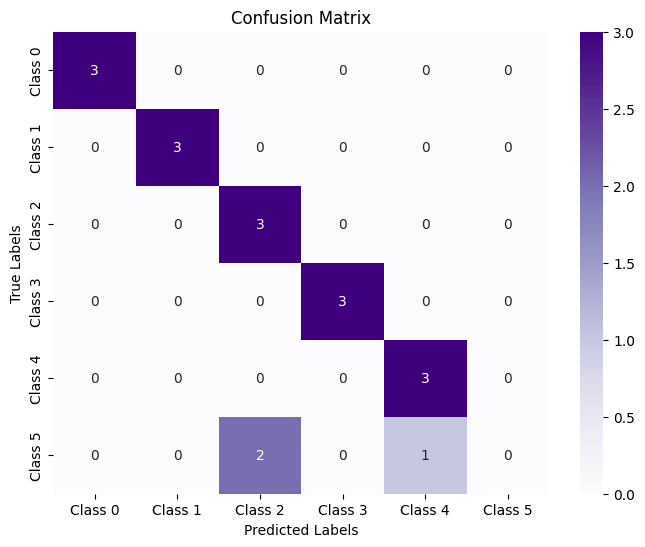

In [19]:
# Generate the confusion matrix
# cm = confusion_matrix(y_true, y_pred_finetune)
cm = confusion_matrix(y_true, y_pred_pretrained)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()